# Modeling - First Pass

### Installs, Packages, Seeds

In [1]:
%pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch
# %pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from itertools import combinations, product

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

# custom modeling libraries
from build_model2 import initialize_model, load_split_data, build_loader, evaluate, train_model, model_scores, eval_model, add_results

# other
import importlib

In [4]:
import build_model2
importlib.reload(build_model2)

from build_model2 import initialize_model, load_split_data, build_loader, evaluate, train_model, model_scores, eval_model, add_results

# import matplotlib as mpl
# print(mpl.get_cachedir())

## Grid Components

In [78]:
epoch_search = [20, 50]
# optim_search = ['SGD']
model_search = ['resnet', 'vgg']
lr_search = [.003, .0035]
split_search = ['split_8', 'split_9', 'split_10']

prods = list(product(epoch_search, model_search, lr_search, split_search))

es = pd.Series(list(zip(*prods))[0], name = 'epochs', dtype = 'int')
mods = pd.Series(list(zip(*prods))[1], name = 'pretrained_model')
learns = pd.Series(list(zip(*prods))[2], name = 'learning_rate')
splits = pd.Series(list(zip(*prods))[3], name = 'data_split')

g_search = pd.concat([es, mods, learns, splits], axis = 1)

In [79]:
g_search

,epochs,pretrained_model,learning_rate,data_split
0,20,resnet,0.0030,split_8
1,20,resnet,0.0030,split_9
2,20,resnet,0.0030,split_10
3,20,resnet,0.0035,split_8
4,20,resnet,0.0035,split_9
5,20,resnet,0.0035,split_10
6,20,vgg,0.0030,split_8
7,20,vgg,0.0030,split_9
8,20,vgg,0.0030,split_10
9,20,vgg,0.0035,split_8


In [86]:
g_search = g_search.iloc[[3, 4, 5, 12, 13, 14, 18, 19, 20]]
g_search.index+=200 # index to add to prior run

In [87]:
g_search

,epochs,pretrained_model,learning_rate,data_split
203,20,resnet,0.0035,split_8
204,20,resnet,0.0035,split_9
205,20,resnet,0.0035,split_10
212,50,resnet,0.0030,split_8
213,50,resnet,0.0030,split_9
214,50,resnet,0.0030,split_10
218,50,vgg,0.0030,split_8
219,50,vgg,0.0030,split_9
220,50,vgg,0.0030,split_10


## Parameters

In [91]:
model_dict = {'pretrained_model': None, 
              'epochs': None, # NEEDS UPDATE
              'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
              'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model/gridsearch4',
              'csv_name': 'full_data_final_not_diverse',
              'split': 'split_3',
              'cl': 'label_0',
              'dev_state': False,
              'dev_sample': 15000,
              'seed': 99,
              'lr': .0035,                  # from prior gridsearch
              'batch_size':64,
              'num_workers':24,
              'transform':3,
              'results_file':'gridsearch_results',
              'model':None, # NEEDS UPDATE
              'device': torch.device('cuda:0'), # NEEDS UPDATE
              'optimizer': None, # NEEDS UPDATE
              'criterion': None, # NEEDS UPDATE
              'tuned_model_name': None, # NEEDS UPDATE
              'show_val_cm': False,
             }

np.random.seed(model_dict['seed'])
torch.cuda.manual_seed(model_dict['seed'])

# Check GPU
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

HOME = model_dict['home_directory']

GPU Type: Tesla T4
GPU Count: 1


In [92]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


## Data

In [10]:
# data, train, test, val = load_split_data(directory = model_dict['home_directory'],
#                                          csv_name = model_dict['csv_name'], 
#                                          data_split = model_dict['split'], 
#                                          label = model_dict['cl'],
#                                          mode = 'all',
#                                          dev_state = model_dict['dev_state'], 
#                                          dev_sample = model_dict['dev_sample'], 
#                                          seed = model_dict['seed']
#                                          )

In [11]:
# # Label dictionary for evaluation
# labels_idx = np.sort(data.label_idx.unique())
# label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
# label_dict = dict(zip(label_map.label_idx, label_map['label']))
# model_dict['label_dict'] = label_dict

## In for loop

In [93]:
model_dict['split']

'split_3'

In [ ]:
# Gridsearch

for i in g_search.iterrows():

    # extract gridsearch features
    model_dict['epochs'] = i[1]['epochs']
    model_dict['pretrained_model'] = i[1]['pretrained_model']
    model_dict['optimizer_name'] = 'SGD'
    model_dict['lr'] = i[1]['learning_rate']
    model_dict['split'] = i[1]['data_split']
    me = i[1]['epochs']
    mn = i[1]['pretrained_model']
    mo = model_dict['optimizer_name']
    ms = model_dict['split']
    mlr = i[1]['learning_rate']
    model_dict['alias'] = i[0]
    model_dict['tuned_model_name'] = f'{mn}_{me}e_{mo}_{ms}_GS{i[0]}'
    direc = model_dict['mod_directory']
    nam = model_dict['tuned_model_name']
    print(f'Learning Rate: {mlr}')
    
    # data for each split
    data, train, test, val = load_split_data(directory = model_dict['home_directory'],
                                             csv_name = model_dict['csv_name'], 
                                             data_split = model_dict['split'], 
                                             label = model_dict['cl'],
                                             mode = 'all',
                                             dev_state = model_dict['dev_state'], 
                                             dev_sample = model_dict['dev_sample'], 
                                             seed = model_dict['seed']
                                             )
    
    # Label dictionary for evaluation
    labels_idx = np.sort(data.label_idx.unique())
    label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
    label_dict = dict(zip(label_map.label_idx, label_map['label']))
    model_dict['label_dict'] = label_dict
    
    # set batch size
    if model_dict['pretrained_model'] == 'efficientnet':
        model_dict['batch_size'] = 3
    else: 
        model_dict['batch_size'] = 64
    
    # Load each model
    model_ft, input_size = initialize_model(model_name = model_dict['pretrained_model'], 
                                            num_classes = len(data.label.unique()),
                                            feature_extract = False, 
                                            use_pretrained=True)
    
    # Move model to GPU
    model = model_ft.to(model_dict['device'])
    
    model_dict.update({
                       'model':model,
                       'criterion': nn.CrossEntropyLoss().to(model_dict['device']),
    })
    
    # Define optimizer options:
    if model_dict['optimizer_name'] == 'SGD':
        model_dict.update({'optimizer': optim.SGD(model.parameters(), lr=model_dict['lr'])})
    elif model_dict['optimizer_name'] == 'Adam':
        model_dict.update({'optimizer': optim.Adam(model.parameters(), lr=model_dict['lr'])})
    elif model_dict['optimizer_name'] == 'AdamW':
        model_dict.update({'optimizer': optim.AdamW(model.parameters(), lr=model_dict['lr'])})
    
    # Update dictionary
    model_dict['resize'] = int(input_size/.85)

    
    # Set Transforms
    transform_header = [
                        transforms.Resize(model_dict['resize']), #255
                        transforms.CenterCrop(input_size)
                        ]

    transform_body = [
                      transforms.RandomHorizontalFlip(), # a
                      transforms.RandomVerticalFlip(), # b
                      transforms.RandomRotation(20), # c
                      transforms.RandomCrop(size=(input_size,input_size)), # d
#                       transforms.RandomInvert(), transforms.RandomPosterize(bits=2), # e
#                       transforms.RandomAdjustSharpness(sharpness_factor=2), # f
#                       transforms.RandomSolarize(threshold=192.0), # g
#                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1) # h
                      ]

    transform_footer = [transforms.ToTensor(), 
                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])]
    
    val_transform = transforms.Compose([
                                      transforms.Resize(model_dict['resize']),
                                      transforms.CenterCrop(input_size),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])
    
    test_loader = build_loader(mode = 'test', df = test, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
    val_loader = build_loader(mode = 'val', df = val, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])   
    
    transform_list = transform_header + transform_body + transform_footer
    train_transform = transforms.Compose(transform_list)
    train_loader = build_loader(mode = 'train', df = train, transform = train_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])


    loaders = {'train_loader':train_loader,
                            'val_loader': val_loader,
                            'test_loader': test_loader}
    model_dict['loader'] = loaders

    pred_df, val_scores, tot_time = train_model(model_dict = model_dict)

    acc, f1, f2, f5, prec, rec, d_0, d_1, d_2, d_3, d_4 = val_scores
    

    pred_df.to_pickle(f'{direc}/{nam}_preds.pkl')
    
    col_dict = {
#              'model': pd.Series(dtype = 'int'),
#              'file': pd.Series(dtype = 'str'),
             'tuned_model': model_dict['tuned_model_name'],
             'transform': model_dict['transform'],
             'lr': model_dict['lr'],
             'pretrained_model': model_dict['pretrained_model'],
             'optimizer': model_dict['optimizer_name'],
             'epochs': model_dict['epochs'],
#              'num_classes': model_dict['num_classes'],
             'batch_size': model_dict['batch_size'],
             'workers': model_dict['num_workers'],
             'train_time': tot_time,
             'data_split': model_dict['split'],
             'label_set': model_dict['cl'],
             'accur': acc,
             'F1': f1,
             'F0.5': f5,
             'F2': f2,
             'benign_accur': d_0,
             'noncancerous_accur': d_1,
             'malignant_accur': d_2,
             'infection_accur': d_3,
             'unclassified_accur': d_4
    }
    
#     print(tdf.iloc[:i[0]+1][['transform', 'lr', 'accur']])
    add_results(model_dict['results_file'], direc, pd.DataFrame(col_dict, index = [i[0]]))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

Learning Rate: 0.0035


/tmp/ipykernel_43722/2014710814.py:23: DtypeWarning: Columns (7,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  data, train, test, val = load_split_data(directory = model_dict['home_directory'],


Starting Training resnet_20e_SGD_split_8_GS203
[epoch 1], [iter 100 of 283],[train loss 1.20957], [train acc 0.51313]
[epoch 1], [iter 200 of 283],[train loss 1.05258], [train acc 0.57617]
------------------------------------------------------------
[epoch 1], [val loss 0.77654], [val acc 0.69153]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 3m 2s
best record: [epoch 1], [val loss 0.77654], [val acc 0.69153]
*****************************************************
[epoch 2], [iter 100 of 283],[train loss 0.79528], [train acc 0.67359]
[epoch 2], [iter 200 of 283],[train loss 0.76984], [train acc 0.68789]
------------------------------------------------------------
[epoch 2], [val loss 0.70934], [val acc 0.71476]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 3m 8s
best record: [epoch 2], [val loss 0.70934], [

/tmp/ipykernel_43722/2014710814.py:23: DtypeWarning: Columns (7,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  data, train, test, val = load_split_data(directory = model_dict['home_directory'],


Starting Training resnet_20e_SGD_split_9_GS204
[epoch 1], [iter 100 of 371],[train loss 1.19382], [train acc 0.52641]
[epoch 1], [iter 200 of 371],[train loss 1.03968], [train acc 0.58297]
[epoch 1], [iter 300 of 371],[train loss 0.96189], [train acc 0.61062]
------------------------------------------------------------
[epoch 1], [val loss 0.75903], [val acc 0.68117]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 4m 19s
best record: [epoch 1], [val loss 0.75903], [val acc 0.68117]
*****************************************************
[epoch 2], [iter 100 of 371],[train loss 0.74514], [train acc 0.69531]
[epoch 2], [iter 200 of 371],[train loss 0.73800], [train acc 0.69914]
[epoch 2], [iter 300 of 371],[train loss 0.73267], [train acc 0.70307]
------------------------------------------------------------
[epoch 2], [val loss 0.68899], [val acc 0.72487]
----------------------------------------------

/tmp/ipykernel_43722/2014710814.py:23: DtypeWarning: Columns (7,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  data, train, test, val = load_split_data(directory = model_dict['home_directory'],


Starting Training resnet_20e_SGD_split_10_GS205
[epoch 1], [iter 100 of 400],[train loss 1.17291], [train acc 0.55359]
[epoch 1], [iter 200 of 400],[train loss 1.02882], [train acc 0.59898]
[epoch 1], [iter 300 of 400],[train loss 0.95388], [train acc 0.62333]
[epoch 1], [iter 400 of 400],[train loss 0.90833], [train acc 0.63924]
------------------------------------------------------------
[epoch 1], [val loss 0.77958], [val acc 0.68509]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 4m 38s
best record: [epoch 1], [val loss 0.77958], [val acc 0.68509]
*****************************************************
[epoch 2], [iter 100 of 400],[train loss 0.73811], [train acc 0.69891]
[epoch 2], [iter 200 of 400],[train loss 0.73083], [train acc 0.70633]
[epoch 2], [iter 300 of 400],[train loss 0.71911], [train acc 0.71391]
[epoch 2], [iter 400 of 400],[train loss 0.71341], [train acc 0.71654]
-------------

/tmp/ipykernel_43722/2014710814.py:23: DtypeWarning: Columns (7,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  data, train, test, val = load_split_data(directory = model_dict['home_directory'],


Starting Training resnet_50e_SGD_split_8_GS212
[epoch 1], [iter 100 of 283],[train loss 1.24683], [train acc 0.51016]
[epoch 1], [iter 200 of 283],[train loss 1.08459], [train acc 0.56742]
------------------------------------------------------------
[epoch 1], [val loss 0.78484], [val acc 0.69001]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 3m 3s
best record: [epoch 1], [val loss 0.78484], [val acc 0.69001]
*****************************************************
[epoch 2], [iter 100 of 283],[train loss 0.80230], [train acc 0.67281]
[epoch 2], [iter 200 of 283],[train loss 0.78680], [train acc 0.68125]
------------------------------------------------------------
[epoch 2], [val loss 0.70348], [val acc 0.71771]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 3m 14s
best record: [epoch 2], [val loss 0.70348], 

/tmp/ipykernel_43722/2014710814.py:23: DtypeWarning: Columns (7,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  data, train, test, val = load_split_data(directory = model_dict['home_directory'],


Starting Training resnet_50e_SGD_split_9_GS213
[epoch 1], [iter 100 of 371],[train loss 1.22408], [train acc 0.53844]
[epoch 1], [iter 200 of 371],[train loss 1.06643], [train acc 0.58555]
[epoch 1], [iter 300 of 371],[train loss 0.98668], [train acc 0.61406]
------------------------------------------------------------
[epoch 1], [val loss 0.76239], [val acc 0.70059]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 4m 17s
best record: [epoch 1], [val loss 0.76239], [val acc 0.70059]
*****************************************************
[epoch 2], [iter 100 of 371],[train loss 0.74997], [train acc 0.69734]
[epoch 2], [iter 200 of 371],[train loss 0.74589], [train acc 0.69883]
[epoch 2], [iter 300 of 371],[train loss 0.74445], [train acc 0.70021]
------------------------------------------------------------
[epoch 2], [val loss 0.69506], [val acc 0.73015]
----------------------------------------------

/tmp/ipykernel_43722/2014710814.py:23: DtypeWarning: Columns (7,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  data, train, test, val = load_split_data(directory = model_dict['home_directory'],


Starting Training resnet_50e_SGD_split_10_GS214
[epoch 1], [iter 100 of 400],[train loss 1.22980], [train acc 0.51141]
[epoch 1], [iter 200 of 400],[train loss 1.06798], [train acc 0.57516]
[epoch 1], [iter 300 of 400],[train loss 0.98759], [train acc 0.60385]
[epoch 1], [iter 400 of 400],[train loss 0.93927], [train acc 0.62164]
------------------------------------------------------------
[epoch 1], [val loss 0.83383], [val acc 0.65299]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 4m 24s
best record: [epoch 1], [val loss 0.83383], [val acc 0.65299]
*****************************************************
[epoch 2], [iter 100 of 400],[train loss 0.74541], [train acc 0.69656]
[epoch 2], [iter 200 of 400],[train loss 0.73961], [train acc 0.70203]
[epoch 2], [iter 300 of 400],[train loss 0.73495], [train acc 0.70427]
[epoch 2], [iter 400 of 400],[train loss 0.73301], [train acc 0.70603]
-------------

In [98]:
g_search

,epochs,pretrained_model,learning_rate,data_split
203,20,resnet,0.0035,split_8
204,20,resnet,0.0035,split_9
205,20,resnet,0.0035,split_10
212,50,resnet,0.0030,split_8
213,50,resnet,0.0030,split_9
214,50,resnet,0.0030,split_10
218,50,vgg,0.0030,split_8
219,50,vgg,0.0030,split_9
220,50,vgg,0.0030,split_10


In [21]:
# model_dict['lr'] = .0035
# model_dict['pretrained_model']
# model_dict['epochs']

10

------------------------------------------------------------
[epoch test], [test loss 0.79331], [test acc 0.67996]
------------------------------------------------------------


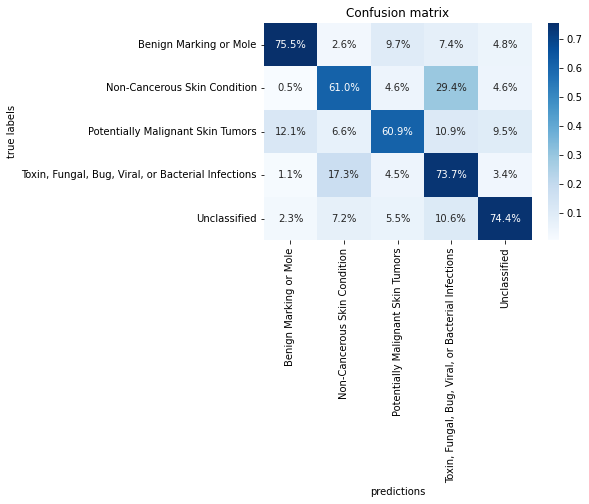

In [28]:
# # resnet_10e_SGD_GS9
pred_df = evaluate(model_name = 'gridsearch2/resnet_10e_SGD_GS9', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.83571], [test acc 0.67349]
------------------------------------------------------------


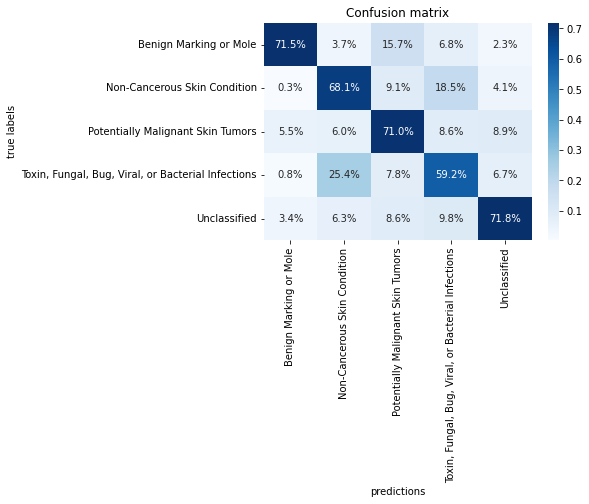

In [29]:
# # vgg_10e_SGD_GS10
pred_df = evaluate(model_name = 'gridsearch2/vgg_10e_SGD_GS10', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.77828], [test acc 0.70151]
------------------------------------------------------------


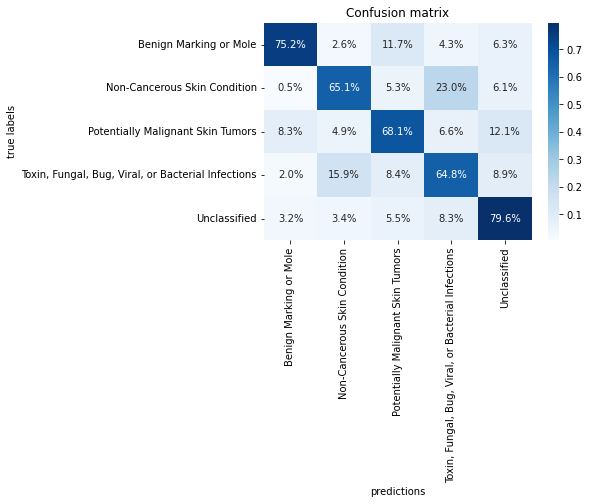

In [30]:
# # resnet_15e_SGD_GS18
pred_df = evaluate(model_name = 'gridsearch2/resnet_15e_SGD_GS18', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.80067], [test acc 0.68858]
------------------------------------------------------------


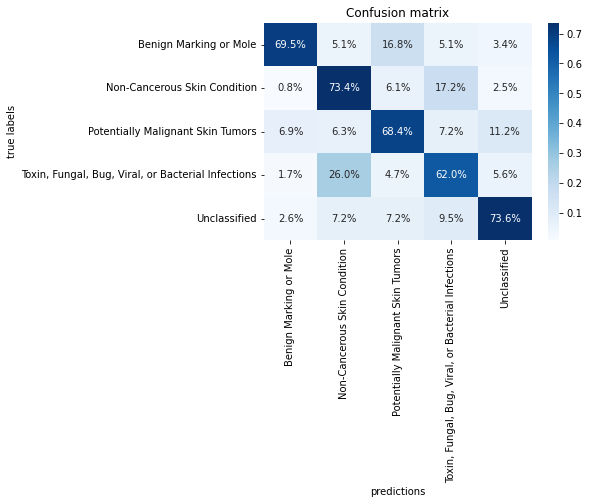

In [31]:
# # vgg_15e_SGD_GS19
pred_df = evaluate(model_name = 'gridsearch2/vgg_15e_SGD_GS19', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.74069], [test acc 0.72899]
------------------------------------------------------------


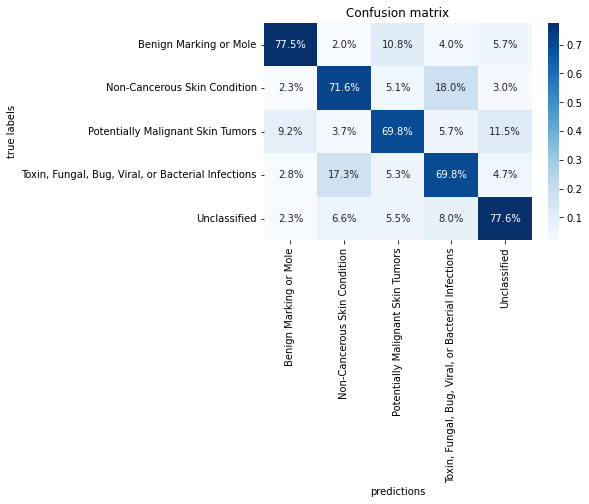

In [32]:
# # resnet_20e_SGD_GS27
pred_df = evaluate(model_name = 'gridsearch2/resnet_20e_SGD_GS27', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.43983], [test acc 0.87051]
------------------------------------------------------------


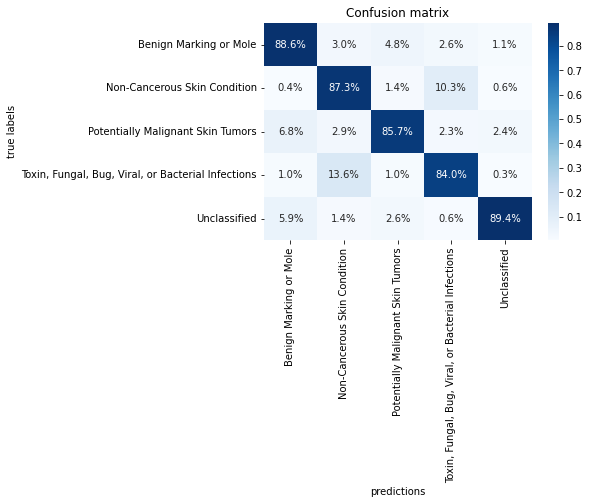

In [109]:

pred_df = evaluate(model_name = 'gridsearch4/resnet_50e_SGD_split_8_GS212', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.57725], [test acc 0.80562]
------------------------------------------------------------


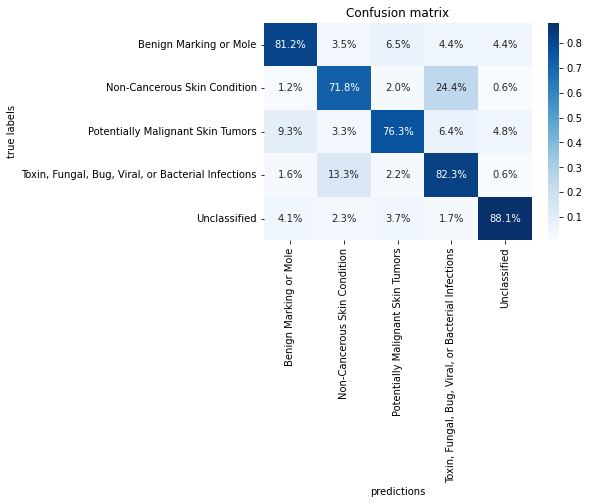

In [106]:
# # 
pred_df = evaluate(model_name = 'gridsearch4/vgg_50e_SGD_split_10_GS220', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

In [44]:
new = pd.read_csv('full_data_final_not_diverse.csv', index_col = 0)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
new.iloc[0].path

'./Data/dermnet/train/Nail Fungus and other Nail Disease/fissure-2.jpg'

In [59]:
new[new.image_id == 'ISIC_0000000'].path[0]

'./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC_0000000.jpg'

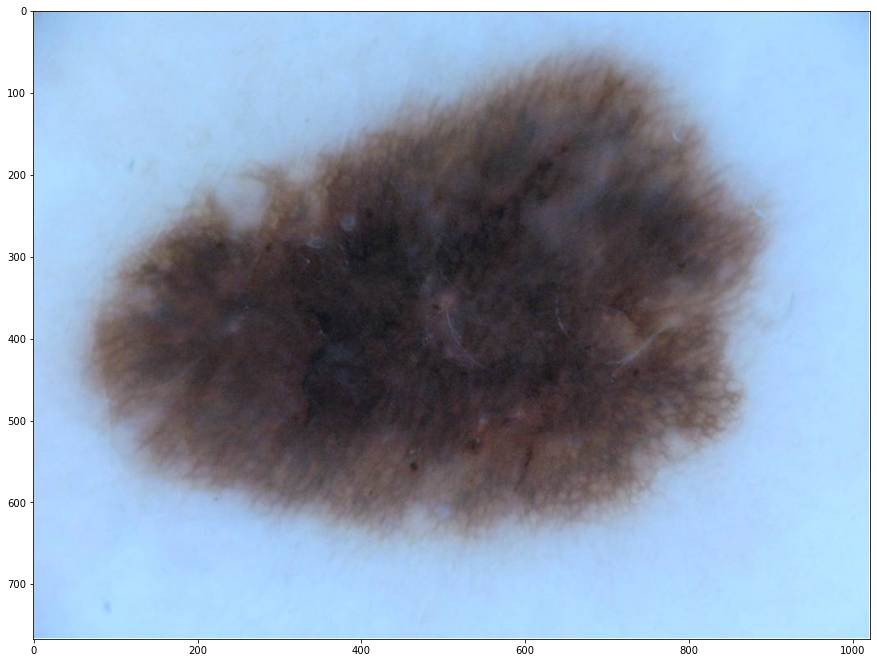

In [65]:
ipath = './Data/ISIC_2019/ISIC_2019_Training_Input/ISIC_0000000.jpg'
image = mp_image.imread(ipath)
# imshow(image)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 15))
axes.imshow(image)

In [63]:
import matplotlib.pyplot.imshow

ModuleNotFoundError: No module named 'matplotlib.pyplot.imshow'; 'matplotlib.pyplot' is not a package